<a href="https://colab.research.google.com/github/RohanOpenSource/ml-notebooks/blob/main/FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow_datasets as tfds
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1

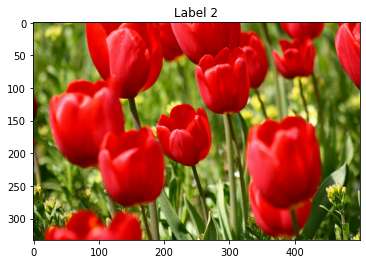

In [5]:
for image, label in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.grid(False)
plt.show()

In [6]:
IMAGE_RES = 224
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

Ok. Time for the convolutional neural network

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation="softmax"))

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
model.fit(train_batches, epochs=30)

Epoch 1/30
81/81 [==============================] - 36s 46ms/step - loss: 1.5495 - accuracy: 0.3846
Epoch 2/30
81/81 [==============================] - 4s 43ms/step - loss: 1.1706 - accuracy: 0.5204
Epoch 3/30
81/81 [==============================] - 3s 43ms/step - loss: 0.9883 - accuracy: 0.6174
Epoch 4/30
81/81 [==============================] - 4s 43ms/step - loss: 0.7341 - accuracy: 0.7256
Epoch 5/30
81/81 [==============================] - 4s 43ms/step - loss: 0.4769 - accuracy: 0.8248
Epoch 6/30
81/81 [==============================] - 4s 43ms/step - loss: 0.2797 - accuracy: 0.9163
Epoch 7/30
81/81 [==============================] - 4s 44ms/step - loss: 0.1953 - accuracy: 0.9424
Epoch 8/30
81/81 [==============================] - 3s 43ms/step - loss: 0.0971 - accuracy: 0.9704
Epoch 9/30
81/81 [==============================] - 4s 43ms/step - loss: 0.0793 - accuracy: 0.9763
Epoch 10/30
81/81 [==============================] - 4s 44ms/step - loss: 0.0416 - accuracy: 0.9907
Epoch 11

Now, lets test it some images.

In [10]:
class_names = np.array(dataset_info.features['label'].names)
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['roses' 'roses' 'sunflowers' 'sunflowers' 'dandelion' 'roses'
 'sunflowers' 'daisy' 'tulips' 'sunflowers' 'dandelion' 'dandelion'
 'dandelion' 'roses' 'tulips' 'tulips' 'tulips' 'tulips' 'tulips' 'roses'
 'dandelion' 'sunflowers' 'dandelion' 'roses' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'sunflowers' 'daisy' 'daisy' 'tulips']


Hmm. This doesn't make much sense. Let's visualize these predictions with the images and the predicted labels.

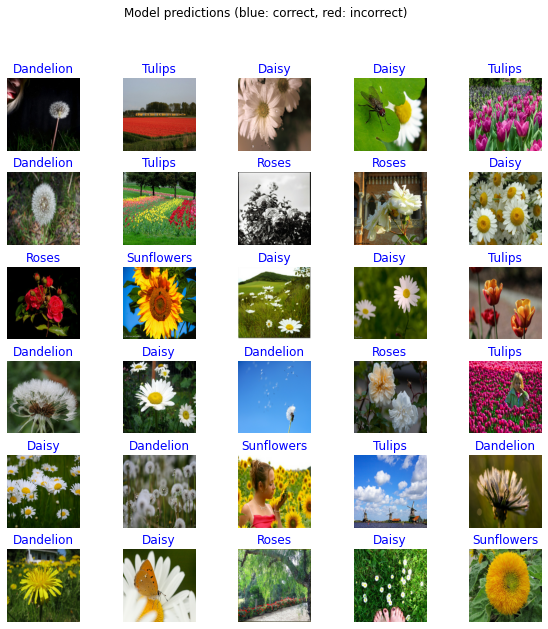

In [9]:
plt.figure(figsize=(10, 10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Great! Time to save the model.

In [11]:
model.save("FlowerClassifier.h5")